# Notebook 2 - Explaining Speech Emotion Recognition - Part 1
##  XAI for Affective Computing with Counterfactuals (SoSe2024)

In this first part of our second Jupyter Notebook assignment, you will attempt to generate counterfactual explanations of a speech emotion recognition (SER) task using tabular data and a XGBoost classifier. 

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

Make sure to read the Notebook 2 section of the **README** beforing starting this notebook for all installation instructions.

## Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

##### Import necessary libraries

(see README for necessary package installations if you receive a `module not found` error.

In [2]:
from pathlib import Path

import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio
import IPython

## Counterfactuals with Tabular Audio Features

### Data and Model

#### Load the Data

First we need to load our datast.  For this task, we will be using the audio portion of the [Ravdess dataset](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio).  

In this task, we provide you with preextracted features in the form of a pandas dataframe.  Tabular features were extracted with the [openSmile](https://audeering.github.io/opensmile-python/) package using the [Extended Geneva Minimalistic Acoustic Parameter
Set (EGeMAPS)](https://mediatum.ub.tum.de/doc/1523509/file.pdf). Please have a look at the paper for a detailed explanation of the different features.

The dataset has been split using actor numbers into a training and testing datasets to ensure there is no data leakage between training and testing the model.  

We are also providing 300 audio clips of the test dataset containing actors \[15,  8, 20, 11,  5\]

Below we load this dataset and display 5 random samples from the training set

In [3]:
LABELS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# load dataframes from CSV
df_train = pd.read_csv('../data/ravdess/features/radvess_opensmile_train.csv')
df_test = pd.read_csv('../data/ravdess/features/radvess_opensmile_test.csv')

# update audio_paths to match new locations
audio_path = Path('../data/ravdess/audio_clips')
def update_paths(row):
    return str(audio_path / Path(row.path).name)
df_train.path = df_train.apply(update_paths, axis='columns')
df_test.path = df_test.apply(update_paths, axis='columns')

# get feature columns
feature_names = list(df_train.columns[6:])

df_train.sample(5)

Unnamed: 0  actor  emotion  intensity  \
161         161      7        4          1   
719         719      6        3          1   
509         509      1        6          1   
995        1055      3        2          1   
279         279     13        5          2   

                                                  path emotion_label  \
161  ../data/ravdess/audio_clips/03-01-05-01-01-02-...         angry   
719  ../data/ravdess/audio_clips/03-01-04-01-01-01-...           sad   
509  ../data/ravdess/audio_clips/03-01-07-01-01-02-...       disgust   
995  ../data/ravdess/audio_clips/03-01-03-01-02-02-...         happy   
279  ../data/ravdess/audio_clips/03-01-06-02-02-02-...          fear   

     F0semitoneFrom27.5Hz_sma3nz_amean  \
161                          36.477695   
719                          36.500710   
509                          31.656343   
995                          31.481632   
279                          27.589066   

     F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
161                                0.157367   
719                                0.036687   
509                                0.222530   
995                                0.211222   
279                                0.095640   

     F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
161                                   35.245132   
719                                   35.357342   
509                                   26.813164   
995                                   25.570381   
279                                   26.469303   

     F0semitoneFrom27.5Hz_sma3nz_percentile50.0  ...  \
161                                   38.183132  ...   
719                                   36.176945  ...   
509                                   30.585526  ...   
995                                   33.159687  ...   
279                                   27.846685  ...   

     slopeUV0-500_sma3nz_amean  slopeUV500-1500_sma3nz_amean  \
161                  -0.024521                      0.004952   
719                   0.054579                      0.004330   
509                   0.074854                      0.010549   
995                   0.096960                      0.015477   
279                   0.002052                      0.010538   

     spectralFluxUV_sma3nz_amean  loudnessPeaksPerSec  VoicedSegmentsPerSec  \
161                     0.040170             2.020202              1.278772   
719                     0.007386             2.808989              1.994302   
509                     0.013459             2.313625              1.822917   
995                     0.025554             2.005731              1.453488   
279                     0.006674             1.880878              0.955414   

     MeanVoicedSegmentLengthSec  StddevVoicedSegmentLengthSec  \
161                    0.356000                      0.264620   
719                    0.110000                      0.037796   
509                    0.175714                      0.159271   
995                    0.236000                      0.193969   
279                    0.353333                      0.313298   

     MeanUnvoicedSegmentLength  StddevUnvoicedSegmentLength  \
161                   0.402000                     0.434391   
719                   0.323750                     0.429242   
509                   0.350000                     0.430747   
995                   0.428000                     0.459234   
279                   0.666667                     0.393813   

     equivalentSoundLevel_dBp  
161                -26.347469  
719                -55.827606  
509                -45.591846  
995                -38.923004  
279                -43.656925  

[5 rows x 94 columns]

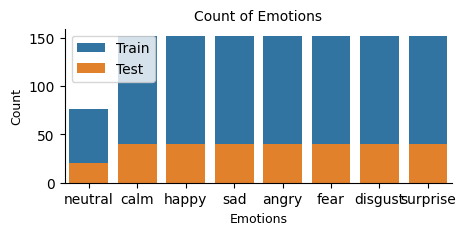

In [4]:
# Plot Label Distribution
plt.figure(figsize=(5,2))

sns.countplot(x= df_train.emotion_label, label='Train', order=LABELS)
sns.countplot(x= df_test.emotion_label, label='Test', order=LABELS)

plt.title('Count of Emotions', size=10)
plt.ylabel('Count', size=9)
plt.xlabel('Emotions', size=9)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.legend()

#### Train XGBoost Model

Now we train an XGBoost model to perform explanations.  The model should get $100\%$ on the training data.

In [5]:
random_state = 24

xgb = XGBClassifier(n_estimators=20, 
                    max_depth=15,
                    learning_rate=0.1, 
                    objective='binary:logistic',
                    random_state=random_state)

xgb.fit(df_train[feature_names], df_train['emotion'])
score = xgb.score(df_train[feature_names], df_train['emotion'])
print(f'Train Accuracy: {score*100:.2f}%')

Train Accuracy: 100.00%


#### Evaluate the model

Now let's evaluate the performance of the RDF Classifier on the `X_aus` dataset. The accuracy should be around $45.67\%$, indicating significant overfitting. However, it is much better than random guessing at $12.5\%$

We should also generate the predictions of the model for the dataset, and store them in the dataframe.

In [6]:
score = xgb.score(df_test[feature_names], df_test['emotion'])
print(f'Test Accuracy: {score*100:.2f}%')

# generate predictions for later user
df_test['emotion_pred'] = xgb.predict(df_test[feature_names])

Test Accuracy: 45.67%


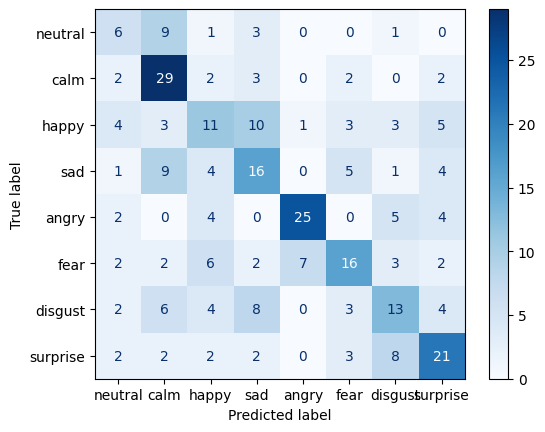

In [7]:
cm = confusion_matrix(df_test['emotion'], df_test['emotion_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues')
plt.grid(False)

### Task 1: Generate Counterfactual Explanations using DiCE

In this part of the notebook, you will generate Counterfactual Explanations using the Python Library, [Diverse Counterfactual Explanations (DiCE)](http://interpret.ml/DiCE/). Make sure to read the documentation and getting started information.

#### Review the Dataset

First let's review some samples to select a few examples.  

Below you can load a random set of samples and then listen to the audio clips.  Make sure to note down the index value for sample that you would like to keep for analysis.  

(note: the audio display function doesn't work if your using PyCharm)

(note you can also filter by emotion if  you prefer. By filtering the data frame, for example: `df_test[df_test['emotion_label'] == 'happy']`

In [13]:
audio_samples = df_test.sample(5, random_state=0)
audio_samples

Unnamed: 0  actor  emotion  intensity  \
208        1348      8        6          1   
188        1328      8        2          2   
12          972      5        5          1   
221        1361      8        6          2   
239        1379      8        1          1   

                                                  path emotion_label  \
208  ../data/ravdess/audio_clips/03-01-07-01-02-01-...       disgust   
188  ../data/ravdess/audio_clips/03-01-03-02-01-02-...         happy   
12   ../data/ravdess/audio_clips/03-01-06-01-01-02-...          fear   
221  ../data/ravdess/audio_clips/03-01-07-02-01-01-...       disgust   
239  ../data/ravdess/audio_clips/03-01-02-01-02-02-...          calm   

     F0semitoneFrom27.5Hz_sma3nz_amean  \
208                          33.104279   
188                          36.570362   
12                           29.906525   
221                          35.314842   
239                          34.319344   

     F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
208                                0.117677   
188                                0.091957   
12                                 0.100353   
221                                0.145752   
239                                0.075051   

     F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
208                                   31.524147   
188                                   32.891212   
12                                    28.000912   
221                                   32.633179   
239                                   33.949970   

     F0semitoneFrom27.5Hz_sma3nz_percentile50.0  ...  \
208                                   34.266598  ...   
188                                   36.405704  ...   
12                                    29.711512  ...   
221                                   35.087833  ...   
239                                   34.532299  ...   

     slopeUV500-1500_sma3nz_amean  spectralFluxUV_sma3nz_amean  \
208                      0.008169                     0.008913   
188                      0.007689                     0.023717   
12                       0.008507                     0.009418   
221                      0.007306                     0.017660   
239                      0.006600                     0.009725   

     loudnessPeaksPerSec  VoicedSegmentsPerSec  MeanVoicedSegmentLengthSec  \
208             2.295918              0.775194                    0.466667   
188             1.799486              0.781250                    0.500000   
12              2.083333              1.510574                    0.198000   
221             2.216749              1.496259                    0.200000   
239             2.890173              0.879765                    0.376667   

     StddevVoicedSegmentLengthSec  MeanUnvoicedSegmentLength  \
208                      0.126842                   0.600000   
188                      0.341272                   0.567500   
12                       0.075472                   0.368333   
221                      0.157586                   0.382857   
239                      0.194308                   0.552500   

     StddevUnvoicedSegmentLength  equivalentSoundLevel_dBp  emotion_pred  
208                     0.430987                -46.100063             1  
188                     0.493071                -35.292259             2  
12                      0.422233                -45.976295             5  
221                     0.469672                -42.587292             3  
239                     0.479290                -51.196003             1  

[5 rows x 95 columns]

In [9]:
for idx, sample in audio_samples.iterrows():
    print(f'Index: {idx} - Emotion: {sample.emotion_label} | Prediction: {LABELS[sample.emotion_pred]}')
    print(sample.path)
    IPython.display.display(IPython.display.Audio(sample.path))

Index: 208 - Emotion: disgust | Prediction: calm
../data/ravdess/audio_clips/03-01-07-01-02-01-08.wav


Index: 188 - Emotion: happy | Prediction: happy
../data/ravdess/audio_clips/03-01-03-02-01-02-08.wav


Index: 12 - Emotion: fear | Prediction: fear
../data/ravdess/audio_clips/03-01-06-01-01-02-05.wav


Index: 221 - Emotion: disgust | Prediction: sad
../data/ravdess/audio_clips/03-01-07-02-01-01-08.wav


Index: 239 - Emotion: calm | Prediction: calm
../data/ravdess/audio_clips/03-01-02-01-02-02-08.wav


#### Task 1.0: Select Your Samples
- After reviewing the samples above, select four that you would like to generate explanations for.
- For each sample, also choose the desired class index that you would like to generate counterfactuals for
    - make sure to think about why we need a "desired class" for counterfactuals and what is important when selecting one

In [48]:
#### Enter the Indexes Here ### 
###############################
# you will use these arrays later in the task
idxs = [188, 12, 239, 208]
desired_classes = [1, 5, 1, 2]

#### Task 1.1: Setup the DiCE Explainer and Generate Explanations
Now it's time to generate the counterfactual explanations.

In [15]:
# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

pd.set_option('display.max_columns', None) # so that Jupyter doesn't truncate columns of dataframe

##### Task 1.1.1 Setup a DiCE explainer instance

See the [intro to DiCE](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html) for details on working with this library.

Note: DiCE requires pandas dataframes for creating explainers and explanations. 
- for setting up the explainer you can use the following to create a dataframe containing only features and the label from the training data
    - `df_train[feature_names+['emotion']`
- for generating a dataframe of a single instance to explain, you can use the following code:
    - `df_test[40:41]` where 40 is the index of instance to explan

In [43]:
##### YOUR CODE GOES HERE #####
###############################

feature_df = df_train[feature_names+['emotion']]

dice_data = dice_ml.Data(dataframe=feature_df, continuous_features=feature_names, outcome_name='emotion')


##### Task 1.1.2: Use the Explainer to Generate Counterfactual Explanations

Generate counterfacutal explanations for each of your selected samples. 

Finding counterfactuals for this task, is sometimes challenging for the model. Therefore, you may get messages indicating that no counterfactuals were found. In this case, you change your "desired_class" or choose another sample

In [44]:
##### YOUR CODE GOES HERE #####
###############################

dice_model = dice_ml.Model(model=xgb, backend="sklearn")

dice_explanation = dice_ml.Dice(dice_data, dice_model, method="random")

In [70]:
counterfactuals = []

df_no_emotion = feature_df.drop(columns=['emotion'])

for idx, desired_class in zip(idxs, desired_classes):
    print(f'Index: {idx} - Desired Class: {LABELS[desired_class]}')
    query_instance = df_no_emotion[idx:idx+1]
    dice_exp = dice_explanation.generate_counterfactuals(query_instance, total_CFs=10, desired_class=desired_class)
    
    counterfactuals.append({
        'idx': idx,
        'desired_class': desired_class,
        'dice_exp': dice_exp
    })

Index: 188 - Desired Class: calm


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Index: 12 - Desired Class: fear


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Index: 239 - Desired Class: calm


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Index: 208 - Desired Class: happy


100%|██████████| 1/1 [01:41<00:00, 101.74s/it]


##### Task 1.1.3: Visualize Counterfactuals

Now visualize the counterfactuals as Pandas dataframes. 

It would also be helpful to include the original audio clip with the explanation, as well as to print the label names for the ground truth, the prediction, and the desired outcome.  

You can use the following to load multiple audio clips in one jupyter cell:
```python
IPython.display.display(IPython.display.Audio(sample.path))
```

In [71]:
##### YOUR CODE GOES HERE #####
###############################

import IPython.display

for counterfactual in counterfactuals:
    # Print the label names for ground truth, prediction, and desired outcome
    print("Ground Truth Label:", LABELS[audio_samples.loc[counterfactual['idx'], 'emotion']])
    print("Predicted Label:", LABELS[audio_samples.loc[counterfactual['idx'], 'emotion_pred']])
    print("Desired Label:", LABELS[counterfactual['desired_class']])

    # Display the original audio clip
    IPython.display.display(IPython.display.Audio(audio_samples.loc[counterfactual['idx'], 'path']))

    # Convert the counterfactuals to a Pandas DataFrame
    counterfactual['dice_exp'].visualize_as_dataframe(show_only_changes=True)


Ground Truth Label: happy
Predicted Label: happy
Desired Label: calm


Query instance (original outcome : 1)


F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                          36.041786                                0.056676   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   34.429817   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   35.293888   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                   38.311768   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                   3.88195   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                     8.933606   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                       4.324537   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                     15.979524   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  \
0                                        7.041442             0.127972   

   loudness_sma3_stddevNorm  loudness_sma3_percentile20.0  \
0                  1.086495                       0.00759   

   loudness_sma3_percentile50.0  loudness_sma3_percentile80.0  \
0                      0.080807                      0.240546   

   loudness_sma3_pctlrange0-2  loudness_sma3_meanRisingSlope  \
0                    0.232956                       1.699413   

   loudness_sma3_stddevRisingSlope  loudness_sma3_meanFallingSlope  \
0                         0.939934                          1.4581   

   loudness_sma3_stddevFallingSlope  spectralFlux_sma3_amean  \
0                          0.687917                 0.026189   

   spectralFlux_sma3_stddevNorm  mfcc1_sma3_amean  mfcc1_sma3_stddevNorm  \
0                      1.272951          9.930445               1.758255   

   mfcc2_sma3_amean  mfcc2_sma3_stddevNorm  mfcc3_sma3_amean  \
0          3.656917               3.740514         -0.449901   

   mfcc3_sma3_stddevNorm  mfcc4_sma3_amean  mfcc4_sma3_stddevNorm  \
0             -27.940035         -3.613744              -3.092715   

   jitterLocal_sma3nz_amean  jitterLocal_sma3nz_stddevNorm  \
0                  0.008533                       1.194428   

   shimmerLocaldB_sma3nz_amean  shimmerLocaldB_sma3nz_stddevNorm  \
0                     0.824794                          0.992052   

   HNRdBACF_sma3nz_amean  HNRdBACF_sma3nz_stddevNorm  \
0               10.24904                    0.284752   

   logRelF0-H1-H2_sma3nz_amean  logRelF0-H1-H2_sma3nz_stddevNorm  \
0                     9.997332                          0.961768   

   logRelF0-H1-A3_sma3nz_amean  logRelF0-H1-A3_sma3nz_stddevNorm  \
0                    24.482281                          0.276852   

   F1frequency_sma3nz_amean  F1frequency_sma3nz_stddevNorm  \
0                529.194275                       0.359677   

   F1bandwidth_sma3nz_amean  F1bandwidth_sma3nz_stddevNorm  \
0               1227.138306                       0.176319   

   F1amplitudeLogRelF0_sma3nz_amean  F1amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -140.686478                              -0.619496   

   F2frequency_sma3nz_amean  F2frequency_sma3nz_stddevNorm  \
0               1553.804077                       0.178939   

   F2bandwidth_sma3nz_amean  F2bandwidth_sma3nz_stddevNorm  \
0                870.327576                         0.3363   

   F2amplitudeLogRelF0_sma3nz_amean  F2amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -132.837814                              -0.646019   

   F3frequency_sma3nz_amean  F3frequency_sma3nz_stddevNorm  \
0               2600.027832                       0.100709   

   F3bandwidth_sma3nz_amean  F3bandwidth_sma3nz_stddevNorm  \
0                 798.78064                       0.398855   

   F3amplitudeLogRelF0_sma3nz_amean  F3amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -136.010208                              -0.598248   

   alphaRatioV_sma3nz_amean  alphaRatioV_sma3nz_


Diverse Counterfactual set (new outcome: 1)


F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                 -                                      -   
1                                 -                                      -   
2                                 -                                      -   
3                                 -                                      -   
4                                 -                                      -   
5                                 -                                      -   
6                                 -                                      -   
7                                 -                                      -   
8                                 -                                      -   
9                                 -                                      -   

  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                   42.72221   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                        -   
1                                        -   
2                                        -   
3                                        -   
4                                        -   
5                                        -   
6                                        -   
7                                        -   
8                                        -   
9                                        -   

  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                           -   
1                                           -   
2                                           -   
3                                           -   
4                                           -   
5                                           -   
6                                           -   
7                                           -   
8                                           -   
9                                           -   

  F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                             -   
1                                             -   
2                                             -   
3                                             -   
4                                             -   
5                                             -   
6                                             -   
7                                         506.1   
8                                             -   

Ground Truth Label: fear
Predicted Label: fear
Desired Label: fear


Query instance (original outcome : 7)


F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                          23.627865                                0.190047   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   19.169128   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   24.150904   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                    26.88443   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                  7.715302   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                   146.685349   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                     119.696083   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                      51.87114   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  \
0                                       12.285951             0.092942   

   loudness_sma3_stddevNorm  loudness_sma3_percentile20.0  \
0                  1.410607                      0.007468   

   loudness_sma3_percentile50.0  loudness_sma3_percentile80.0  \
0                      0.014181                       0.16553   

   loudness_sma3_pctlrange0-2  loudness_sma3_meanRisingSlope  \
0                    0.158062                       2.542295   

   loudness_sma3_stddevRisingSlope  loudness_sma3_meanFallingSlope  \
0                         1.749261                        2.390273   

   loudness_sma3_stddevFallingSlope  spectralFlux_sma3_amean  \
0                          1.670425                 0.032192   

   spectralFlux_sma3_stddevNorm  mfcc1_sma3_amean  mfcc1_sma3_stddevNorm  \
0                      1.534092         12.349685               1.539608   

   mfcc2_sma3_amean  mfcc2_sma3_stddevNorm  mfcc3_sma3_amean  \
0          9.582627                1.21585         10.909505   

   mfcc3_sma3_stddevNorm  mfcc4_sma3_amean  mfcc4_sma3_stddevNorm  \
0               0.908106          6.861549               1.303478   

   jitterLocal_sma3nz_amean  jitterLocal_sma3nz_stddevNorm  \
0                  0.051613                       1.436072   

   shimmerLocaldB_sma3nz_amean  shimmerLocaldB_sma3nz_stddevNorm  \
0                      1.44053                          0.471468   

   HNRdBACF_sma3nz_amean  HNRdBACF_sma3nz_stddevNorm  \
0               1.768703                    1.972454   

   logRelF0-H1-H2_sma3nz_amean  logRelF0-H1-H2_sma3nz_stddevNorm  \
0                     7.142801                          1.833737   

   logRelF0-H1-A3_sma3nz_amean  logRelF0-H1-A3_sma3nz_stddevNorm  \
0                    23.621767                           0.36547   

   F1frequency_sma3nz_amean  F1frequency_sma3nz_stddevNorm  \
0                677.688416                       0.429171   

   F1bandwidth_sma3nz_amean  F1bandwidth_sma3nz_stddevNorm  \
0               1276.863403                        0.19539   

   F1amplitudeLogRelF0_sma3nz_amean  F1amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -144.224731                              -0.592777   

   F2frequency_sma3nz_amean  F2frequency_sma3nz_stddevNorm  \
0               1742.849243                       0.175132   

   F2bandwidth_sma3nz_amean  F2bandwidth_sma3nz_stddevNorm  \
0               1064.782593                         0.3711   

   F2amplitudeLogRelF0_sma3nz_amean  F2amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -145.993103                              -0.556986   

   F3frequency_sma3nz_amean  F3frequency_sma3nz_stddevNorm  \
0               2689.441406                       0.133228   

   F3bandwidth_sma3nz_amean  F3bandwidth_sma3nz_stddevNorm  \
0                982.651428                       0.422097   

   F3amplitudeLogRelF0_sma3nz_amean  F3amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -146.967422                              -0.543485   

   alphaRatioV_sma3nz_amean  alphaRatioV_sma3nz_


Diverse Counterfactual set (new outcome: 5)


F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                         35.028773                                      -   
1                                 -                                      -   
2                                 -                                      -   
3                                 -                              0.0322796   
4                         35.028773                                      -   
5                                 -                                      -   
6                                 -                                      -   
7                         35.028773                                      -   
8                         35.028773                                      -   
9                                 -                                      -   

  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                        -   
1                                        -   
2                                        -   
3                                        -   
4                                        -   
5                                        -   
6                                        -   
7                                        -   
8                                        -   
9                                        -   

  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                           -   
1                                           -   
2                                           -   
3                                           -   
4                                           -   
5                                           -   
6                                           -   
7                                           -   
8                                           -   
9                                           -   

  F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                             -   
1                                         466.2   
2                                             -   
3                                             -   
4                                             -   
5                                             -   
6                                             -   
7                                             -   
8                                             -   

Ground Truth Label: calm
Predicted Label: calm
Desired Label: calm


Query instance (original outcome : 0)


F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                          37.108871                                 0.05478   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   35.138161   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   37.044052   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                   38.996525   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                  3.858364   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                    31.353891   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                      15.973756   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                     14.085154   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  \
0                                        4.713037             0.140744   

   loudness_sma3_stddevNorm  loudness_sma3_percentile20.0  \
0                  1.300198                      0.001315   

   loudness_sma3_percentile50.0  loudness_sma3_percentile80.0  \
0                      0.012445                      0.282382   

   loudness_sma3_pctlrange0-2  loudness_sma3_meanRisingSlope  \
0                    0.281067                       2.753055   

   loudness_sma3_stddevRisingSlope  loudness_sma3_meanFallingSlope  \
0                          1.25755                        2.772178   

   loudness_sma3_stddevFallingSlope  spectralFlux_sma3_amean  \
0                          1.711918                 0.037331   

   spectralFlux_sma3_stddevNorm  mfcc1_sma3_amean  mfcc1_sma3_stddevNorm  \
0                      1.395673         10.897525               1.571164   

   mfcc2_sma3_amean  mfcc2_sma3_stddevNorm  mfcc3_sma3_amean  \
0          1.435469               9.253448         -1.560818   

   mfcc3_sma3_stddevNorm  mfcc4_sma3_amean  mfcc4_sma3_stddevNorm  \
0              -7.697221         -7.511199              -1.811835   

   jitterLocal_sma3nz_amean  jitterLocal_sma3nz_stddevNorm  \
0                  0.016709                       1.561557   

   shimmerLocaldB_sma3nz_amean  shimmerLocaldB_sma3nz_stddevNorm  \
0                     0.987662                          0.845326   

   HNRdBACF_sma3nz_amean  HNRdBACF_sma3nz_stddevNorm  \
0               8.491134                    0.678172   

   logRelF0-H1-H2_sma3nz_amean  logRelF0-H1-H2_sma3nz_stddevNorm  \
0                     8.257078                           1.56698   

   logRelF0-H1-A3_sma3nz_amean  logRelF0-H1-A3_sma3nz_stddevNorm  \
0                    21.613073                          0.434116   

   F1frequency_sma3nz_amean  F1frequency_sma3nz_stddevNorm  \
0                480.647827                       0.391386   

   F1bandwidth_sma3nz_amean  F1bandwidth_sma3nz_stddevNorm  \
0               1182.401367                       0.219583   

   F1amplitudeLogRelF0_sma3nz_amean  F1amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -144.803848                              -0.597266   

   F2frequency_sma3nz_amean  F2frequency_sma3nz_stddevNorm  \
0               1505.075317                       0.188817   

   F2bandwidth_sma3nz_amean  F2bandwidth_sma3nz_stddevNorm  \
0                989.291687                       0.599766   

   F2amplitudeLogRelF0_sma3nz_amean  F2amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -130.203003                              -0.678492   

   F3frequency_sma3nz_amean  F3frequency_sma3nz_stddevNorm  \
0               2505.866699                        0.13503   

   F3bandwidth_sma3nz_amean  F3bandwidth_sma3nz_stddevNorm  \
0                 740.85553                       0.319995   

   F3amplitudeLogRelF0_sma3nz_amean  F3amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -132.358322                              -0.644685   

   alphaRatioV_sma3nz_amean  alphaRatioV_sma3nz_


Diverse Counterfactual set (new outcome: 1)


F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                 -                                      -   
1                                 -                                      -   
2                                 -                                      -   
3                                 -                                      -   
4                                 -                                      -   
5                                 -                                      -   
6                                 -                                      -   
7                         19.550024                                      -   
8                                 -                                      -   
9                                 -                                      -   

  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                        -   
1                                        -   
2                                        -   
3                                        -   
4                                        -   
5                                        -   
6                                        -   
7                                        -   
8                                        -   
9                                        -   

  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                           -   
1                                           -   
2                                           -   
3                                           -   
4                                           -   
5                                           -   
6                                           -   
7                                           -   
8                                           -   
9                                           -   

  F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                             -   
1                                             -   
2                                             -   
3                                             -   
4                                             -   
5                                             -   
6                                             -   
7                                             -   
8                                             -   

Ground Truth Label: disgust
Predicted Label: calm
Desired Label: happy


Query instance (original outcome : 4)


F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                          37.737667                                0.062317   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   36.345921   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   37.703411   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                   39.162189   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                  2.816269   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                    62.051891   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                      47.370781   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                      29.88678   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  \
0                                       16.221739             0.475435   

   loudness_sma3_stddevNorm  loudness_sma3_percentile20.0  \
0                  1.410526                       0.00105   

   loudness_sma3_percentile50.0  loudness_sma3_percentile80.0  \
0                       0.14233                      0.894182   

   loudness_sma3_pctlrange0-2  loudness_sma3_meanRisingSlope  \
0                    0.893132                      10.269565   

   loudness_sma3_stddevRisingSlope  loudness_sma3_meanFallingSlope  \
0                         8.069574                        9.756858   

   loudness_sma3_stddevFallingSlope  spectralFlux_sma3_amean  \
0                          4.931464                 0.237607   

   spectralFlux_sma3_stddevNorm  mfcc1_sma3_amean  mfcc1_sma3_stddevNorm  \
0                       1.60453          8.605968               1.470174   

   mfcc2_sma3_amean  mfcc2_sma3_stddevNorm  mfcc3_sma3_amean  \
0         -2.758836              -5.091079         -1.618422   

   mfcc3_sma3_stddevNorm  mfcc4_sma3_amean  mfcc4_sma3_stddevNorm  \
0             -10.793487        -13.822596              -1.472235   

   jitterLocal_sma3nz_amean  jitterLocal_sma3nz_stddevNorm  \
0                  0.021471                       1.285974   

   shimmerLocaldB_sma3nz_amean  shimmerLocaldB_sma3nz_stddevNorm  \
0                     1.193324                          0.828908   

   HNRdBACF_sma3nz_amean  HNRdBACF_sma3nz_stddevNorm  \
0               6.910562                    0.711171   

   logRelF0-H1-H2_sma3nz_amean  logRelF0-H1-H2_sma3nz_stddevNorm  \
0                     3.232887                          3.387993   

   logRelF0-H1-A3_sma3nz_amean  logRelF0-H1-A3_sma3nz_stddevNorm  \
0                    12.809606                          0.649905   

   F1frequency_sma3nz_amean  F1frequency_sma3nz_stddevNorm  \
0                702.152893                       0.423077   

   F1bandwidth_sma3nz_amean  F1bandwidth_sma3nz_stddevNorm  \
0               1066.645752                       0.272174   

   F1amplitudeLogRelF0_sma3nz_amean  F1amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -134.941711                              -0.676779   

   F2frequency_sma3nz_amean  F2frequency_sma3nz_stddevNorm  \
0               1815.832886                       0.193337   

   F2bandwidth_sma3nz_amean  F2bandwidth_sma3nz_stddevNorm  \
0                700.939758                        0.60049   

   F2amplitudeLogRelF0_sma3nz_amean  F2amplitudeLogRelF0_sma3nz_stddevNorm  \
0                        -116.73484                              -0.797126   

   F3frequency_sma3nz_amean  F3frequency_sma3nz_stddevNorm  \
0               2864.612549                       0.147981   

   F3bandwidth_sma3nz_amean  F3bandwidth_sma3nz_stddevNorm  \
0                709.354492                       0.543249   

   F3amplitudeLogRelF0_sma3nz_amean  F3amplitudeLogRelF0_sma3nz_stddevNorm  \
0                       -117.443138                              -0.782598   

   alphaRatioV_sma3nz_amean  alphaRatioV_sma3nz_


Diverse Counterfactual set (new outcome: 2)


F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                 -                                      -   
1                                 -                                      -   
2                                 -                                      -   
3                                 -                                      -   
4                                 -                                      -   
5                                 -                                      -   
6                                 -                              0.2530488   
7                         26.969907                                      -   
8                                 -                              0.2530488   
9                                 -                                      -   

  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                   51.56071   
6                                   37.22254   
7                                          -   
8                                   37.22254   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                   50.93224   
5                                   46.55115   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                          -   
1                                          -   
2                                          -   
3                                          -   
4                                          -   
5                                          -   
6                                          -   
7                                          -   
8                                          -   
9                                          -   

  F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                        -   
1                                        -   
2                                        -   
3                                        -   
4                                        -   
5                                        -   
6                                        -   
7                                        -   
8                                        -   
9                                        -   

  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                   1550.9017   
1                                           -   
2                                           -   
3                                           -   
4                                           -   
5                                           -   
6                                           -   
7                                           -   
8                                           -   
9                                           -   

  F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                             -   
1                                             -   
2                                             -   
3                                             -   
4                                        1683.5   
5                                             -   
6                                             -   
7                                             -   
8                                             -   

#### Task 1.2: Describe your observations

1. What is your first impression of counterfactuals for this dataset and task?
2. Would another task or dataset be more suited for this approach?
3. Which features are most important for the detection of the specific emotions in your selections? Can you find any patterns?  Do the counterfactuals make sense according to your intuition of the contrastive expression class you're using?
2. The `generate_counterfactuals` method has a parameter `features_to_vary` so that we can restrict which features are perturbed in CF generation.  Are there any features that shouldn't be perturbed for our task of emotion detection? Why or why not? Additionally, should we set `permitted_range` parameter to limit the ranges of our continous features?


Answer here...

### Task 2: Generate Feature Attribution Scores from Counterfactuals

DiCE can also generate [local and global feature attribution scores](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html#Generating-feature-attributions-(local-and-global)-using-DiCE) based on the identified counterfactuals.  In this task, we will do just that.  

In [53]:
# function for plotting importance dictionaries provided by DiCE
def plot_importance_dict(importance_dict, top_n):
    keys = list(importance_dict.keys())[:top_n]
    vals = [float(importance_dict[k]) for k in keys][:top_n]
    sns.barplot(x=keys, y=vals)
    plt.xticks(rotation=90)

#### Task 2.1 Generate and Plot Local Importance Scores

Using your previously defined DiCE explainer, generate and plot (with the help of the function above) local importance scores of your data instances.

Again, it is helpful to also include the original audio sample and feature values, as well as to print the label names for the ground truth, the prediction, and the desired outcome.   

In [73]:
##### YOUR CODE GOES HERE #####
###############################
from IPython.display import display # (use display to display a dataframe)

for counterfactual in counterfactuals:
    idx = counterfactual['idx']
    
    print(f'Index: {idx}')
    print("Ground Truth Label:", LABELS[audio_samples.loc[idx, 'emotion']])
    print("Predicted Label:", LABELS[audio_samples.loc[idx, 'emotion_pred']])
    print("Desired Label:", LABELS[counterfactual['desired_class']])
    # Display the original audio clip
    IPython.display.display(IPython.display.Audio(audio_samples.loc[idx, 'path']))
    
    query_instance = df_no_emotion[idx:idx+1]
    try:
        imp = dice_explanation.local_feature_importance(query_instance, total_CFs=10)
        print('Importance')
        plot_importance_dict(imp, 10)
        plt.show()
    except Exception as e:
        print('Error:', e)


Index: 188
Ground Truth Label: happy
Predicted Label: happy
Desired Label: calm


  0%|          | 0/1 [00:00<?, ?it/s]

Error: Desired class cannot be opposite if the number of classes is more than 2.
Index: 12
Ground Truth Label: fear
Predicted Label: fear
Desired Label: fear


  0%|          | 0/1 [00:00<?, ?it/s]

Error: Desired class cannot be opposite if the number of classes is more than 2.
Index: 239
Ground Truth Label: calm
Predicted Label: calm
Desired Label: calm


  0%|          | 0/1 [00:00<?, ?it/s]

Error: Desired class cannot be opposite if the number of classes is more than 2.
Index: 208
Ground Truth Label: disgust
Predicted Label: calm
Desired Label: happy


  0%|          | 0/1 [00:00<?, ?it/s]

Error: Desired class cannot be opposite if the number of classes is more than 2.


#### Task 2.2 Generate and Plot Global Importance Scores

Using your previously defined DiCE explainer, generate and plot global importance using the entire XAI dataset.

In [17]:
##### YOUR CODE GOES HERE #####
###############################

#### Task 2.3 Describe your findings


1. Based on the DiCE documentation, how does DiCE calculate feature importance from counterfactuals?
2. Do the plots match your expectations for each emotion or do they lead to any interesting insights regarding AUs or facial expression detection?

Write your answer here...